# Clustering Crypto

In [18]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

### Fetching Cryptocurrency Data

In [6]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [13]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

request_url = requests.get(url)
request_url.content

b'{"Response":"Success","Message":"Coin list succesfully returned!","Data":{"42":{"Id":"4321","Url":"/coins/42/overview","ImageUrl":"/media/35650717/42.jpg","ContentCreatedOn":1427211129,"Name":"42","Symbol":"42","CoinName":"42 Coin","FullName":"42 Coin (42)","Description":"Everything about 42 coin is 42 - apart from the transaction fees and difficulty retargetting - 0.00000001 and 7.5mins. A scrypt coin with 42 coins max, a 42 second block time, with superblocks giving 10 times the standard block reward of 0.0000420 42&#39;s.42 coin is a cryptocurrency with completed emission, fair distribution (no ICO, premine or instamine) and both private and public transaction support. The maximum supply of 42 coins makes the remaining 41.99 extremely rare. The innovative deflationary model provides a constant rise in incentives both for miners and long term investors. 42-coin delivers a hybrid of Proof-of-Work and Proof-of-Stake transaction confirmation methods and represents a new way of securin

In [199]:
pd.DataFrame(request_url).head()

0
0  b'{"Response":"Success","Message":"Coin list s...
1  b'":"/media/35650717/42.jpg","ContentCreatedOn...
2  b'","Description":"Everything about 42 coin is...
3  b'.5mins. A scrypt coin with 42 coins max, a 4...
4  b'.0000420 42&#39;s.42 coin is a cryptocurrenc...

In [218]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

crypto_df = pd.read_csv(file_path)
crypto_df.head()

Unnamed: 0   CoinName Algorithm  IsTrading ProofType  TotalCoinsMined  \
0         42    42 Coin    Scrypt       True   PoW/PoS     4.199995e+01   
1        365    365Coin       X11       True   PoW/PoS              NaN   
2        404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09   
3        611  SixEleven   SHA-256       True       PoW              NaN   
4        808        808   SHA-256       True   PoW/PoS     0.000000e+00   

  TotalCoinSupply  
0              42  
1      2300000000  
2       532000000  
3          611000  
4               0

### Data Preprocessing

In [219]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df.drop(columns=['Unnamed: 0'], inplace=True)
crypto_df.head()

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
0    42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
1    365Coin       X11       True   PoW/PoS              NaN      2300000000
2    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
3  SixEleven   SHA-256       True       PoW              NaN          611000
4        808   SHA-256       True   PoW/PoS     0.000000e+00               0

In [220]:
# Keep only cryptocurrencies that are trading
crypto_df=crypto_df[(crypto_df['IsTrading']==True)]

In [221]:
# Keep only cryptocurrencies with a working algorithm
crypto_df['Algorithm'].isnull().sum()

0

In [222]:
# Remove the "IsTrading" column
crypto_df.drop(columns= ["IsTrading"], inplace = True)
crypto_df

CoinName    Algorithm ProofType  TotalCoinsMined TotalCoinSupply
0         42 Coin       Scrypt   PoW/PoS     4.199995e+01              42
1         365Coin          X11   PoW/PoS              NaN      2300000000
2         404Coin       Scrypt   PoW/PoS     1.055185e+09       532000000
3       SixEleven      SHA-256       PoW              NaN          611000
4             808      SHA-256   PoW/PoS     0.000000e+00               0
...           ...          ...       ...              ...             ...
1243   Super Zero       Ethash       PoW              NaN      1000000000
1244          UOS      SHA-256      DPoI              NaN      1000000000
1245       Beldex  CryptoNight       PoW     9.802226e+08      1400222610
1246      Horizen     Equihash       PoW     7.296538e+06        21000000
1247  BitcoinPlus       Scrypt       PoS     1.283270e+05         1000000

[1144 rows x 5 columns]

In [223]:
# Remove rows with at least 1 null value
crypto_df.isnull().sum()

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [224]:
crypto_df = crypto_df.dropna()

In [225]:
crypto_df.isnull().sum()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [226]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df["TotalCoinsMined"].value_counts()

0.000000e+00    152
1.000000e+08      7
1.000000e+09      7
2.000000e+07      2
2.500000e+07      2
               ... 
2.298693e+07      1
8.377873e+06      1
7.296538e+06      1
2.689812e+06      1
9.106714e+06      1
Name: TotalCoinsMined, Length: 520, dtype: int64

In [227]:
crypto_df.drop_duplicates(subset = 'TotalCoinsMined', keep = False, inplace = True)

In [228]:
crypto_df.head()

CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
0    42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
2    404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
5  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
7    Bitcoin   SHA-256       PoW     1.792718e+07        21000000
8   Ethereum    Ethash       PoW     1.076842e+08               0

In [229]:
# Drop rows where there are 'N/A' text values
crypto_df.isna().sum(axis=0)

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [230]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
CoinName = crypto_df["CoinName"].to_frame()

In [231]:
pd.DataFrame(CoinName)

CoinName
0         42 Coin
2         404Coin
5       EliteCoin
7         Bitcoin
8        Ethereum
...           ...
1238       ZEPHYR
1242      Gapcoin
1245       Beldex
1246      Horizen
1247  BitcoinPlus

[515 rows x 1 columns]

In [232]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns = ['CoinName'], inplace = True)

In [233]:
crypto_df.head()

Algorithm ProofType  TotalCoinsMined TotalCoinSupply
0    Scrypt   PoW/PoS     4.199995e+01              42
2    Scrypt   PoW/PoS     1.055185e+09       532000000
5       X13   PoW/PoS     2.927942e+10    314159265359
7   SHA-256       PoW     1.792718e+07        21000000
8    Ethash       PoW     1.076842e+08               0

In [238]:
# Create dummy variables for text features
crypto_dummy = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'])

crypto_dummy.head()

TotalCoinsMined TotalCoinSupply  Algorithm_1GB AES Pattern Search  \
0     4.199995e+01              42                                 0   
2     1.055185e+09       532000000                                 0   
5     2.927942e+10    314159265359                                 0   
7     1.792718e+07        21000000                                 0   
8     1.076842e+08               0                                 0   

   Algorithm_536  Algorithm_Argon2d  Algorithm_BLAKE256  Algorithm_Blake  \
0              0                  0                   0                0   
2              0                  0                   0                0   
5              0                  0                   0                0   
7              0                  0                   0                0   
8              0                  0                   0                0   

   Algorithm_Blake2S  Algorithm_Blake2b  Algorithm_C11  ...  \
0                  0                  0              0  ...   
2                  0                  0              0  ...   
5                  0                  0              0  ...   
7                  0                  0              0  ...   
8                  0                  0              0  ...   

   ProofType_PoW and PoS  ProofType_PoW/PoS  ProofType_PoW/PoS   \
0                      0                  1                   0   
2                      0                  1                   0   
5                      0                  1                   0   
7                      0                  0                   0   
8                      0                  0                   0   

   ProofType_PoW/PoW  ProofType_PoW/nPoS  ProofType_Pos  \
0                  0                   0              0   
2                  0                   0              0   
5                  0                   0              0   
7                  0                   0              0   
8                  0                   0              0   

   ProofType_Proof of Authority  ProofType_Proof of Trust  ProofType_TPoS  \
0                             0                         0               0   
2                             0                         0               0   
5                             0                         0               0   
7                             0                         0               0   
8                             0                         0               0   

   ProofType_dPoW/PoW  
0                   0  
2                   0  
5                   0  
7                   0  
8                   0  

[5 rows x 91 columns]

In [242]:
# Standardize data
crypto_scaler = StandardScaler().fit_transform(crypto_dummy)
print(crypto_scaler[0:1])

[[-0.11846829 -0.15528911 -0.04410811 -0.04410811 -0.04410811 -0.06243905
  -0.07654655 -0.04410811 -0.06243905 -0.06243905 -0.04410811 -0.04410811
  -0.19572034 -0.06243905 -0.09901475 -0.04410811 -0.10857172 -0.07654655
  -0.04410811 -0.15445666 -0.13336627 -0.04410811 -0.04410811 -0.08847479
  -0.04410811 -0.04410811 -0.04410811 -0.06243905 -0.08847479 -0.08847479
  -0.08847479 -0.04410811 -0.11738623 -0.14071951 -0.14071951 -0.04410811
  -0.06243905 -0.04410811 -0.06243905 -0.16716492 -0.04410811 -0.04410811
  -0.04410811 -0.07654655 -0.16092363 -0.31690275 -0.04410811 -0.08847479
  -0.04410811 -0.06243905 -0.04410811  1.37007116 -0.04410811 -0.04410811
  -0.06243905 -0.04410811 -0.04410811 -0.04410811 -0.04410811 -0.04410811
  -0.04410811 -0.04410811 -0.04410811 -0.40639681 -0.04410811 -0.18476078
  -0.08847479 -0.08847479 -0.10857172 -0.04410811 -0.12561486 -0.04410811
  -0.04410811 -0.04410811 -0.07654655 -0.42566731 -0.06243905 -0.04410811
  -0.04410811 -0.91254601 -0.04410811 

### Reducing Dimensions Using PCA

In [180]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)

In [245]:
crypto_pca = pca.fit_transform(crypto_scaler)

In [246]:
# Create a DataFrame with the principal components data
pca_df=pd.DataFrame(crypto_pca)

In [247]:
pca_df = pca_df.rename(columns = {0: 'PCA1', 1: 'PCA2', 2: 'PCA3'})

In [248]:
pca_df.head()

PCA1      PCA2      PCA3
0 -0.338585  1.111920 -0.501400
1 -0.322225  1.112238 -0.501768
2  2.250359  1.825024 -0.545517
3 -0.148053 -1.311171  0.145892
4 -0.149111 -1.990264  0.315282

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

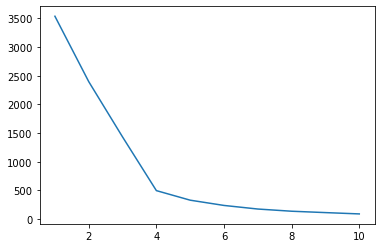

In [250]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i).fit(pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
plt.plot(k,inertia);

Running K-Means with `k=<your best value for k here>`

In [257]:
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=5)
# Fit the model
model.fit(pca_df)
# Predict clusters
predictions = model.predict(pca_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
pca_df["Class"] = model.labels_

df_merge = crypto_df.join(CoinName, how ='outer')
df_merge = df_merge.append(pca_df)
df_merge.head()

Algorithm ProofType  TotalCoinsMined TotalCoinSupply   CoinName  PCA1  PCA2  \
0    Scrypt   PoW/PoS     4.199995e+01              42    42 Coin   NaN   NaN   
2    Scrypt   PoW/PoS     1.055185e+09       532000000    404Coin   NaN   NaN   
5       X13   PoW/PoS     2.927942e+10    314159265359  EliteCoin   NaN   NaN   
7   SHA-256       PoW     1.792718e+07        21000000    Bitcoin   NaN   NaN   
8    Ethash       PoW     1.076842e+08               0   Ethereum   NaN   NaN   

   PCA3  Class  
0   NaN    NaN  
2   NaN    NaN  
5   NaN    NaN  
7   NaN    NaN  
8   NaN    NaN

### Visualizing Results

#### 3D-Scatter with Clusters

In [273]:
df_merge.drop_duplicates(inplace = True)
df_merge

Algorithm ProofType  TotalCoinsMined TotalCoinSupply   CoinName      PCA1  \
0      Scrypt   PoW/PoS     4.199995e+01              42    42 Coin       NaN   
2      Scrypt   PoW/PoS     1.055185e+09       532000000    404Coin       NaN   
5         X13   PoW/PoS     2.927942e+10    314159265359  EliteCoin       NaN   
7     SHA-256       PoW     1.792718e+07        21000000    Bitcoin       NaN   
8      Ethash       PoW     1.076842e+08               0   Ethereum       NaN   
..        ...       ...              ...             ...        ...       ...   
510       NaN       NaN              NaN             NaN        NaN  2.650762   
511       NaN       NaN              NaN             NaN        NaN -0.336669   
512       NaN       NaN              NaN             NaN        NaN  0.299797   
513       NaN       NaN              NaN             NaN        NaN -0.146836   
514       NaN       NaN              NaN             NaN        NaN -0.282256   

         PCA2      PCA3  Class  
0         NaN       NaN    NaN  
2         NaN       NaN    NaN  
5         NaN       NaN    NaN  
7         NaN       NaN    NaN  
8         NaN       NaN    NaN  
..        ...       ...    ...  
510  0.724381 -0.135350    4.0  
511  1.111826 -0.501417    0.0  
512 -2.334252  0.273525    1.0  
513 -1.931011  0.334894    1.0  
514  0.785066 -0.235548    0.0  

[1030 rows x 9 columns]

In [278]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    df_merge,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    hover_name='CoinName',
    hover_data= ['Algorithm'],
    color="Class",
    symbol="Class",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

SyntaxError: invalid syntax (<ipython-input-278-7a8dab43227a>, line 13)

#### Table of Tradable Cryptocurrencies

In [279]:
# Table with tradable cryptos
columns = ['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined', 'Class']

In [281]:
# Print the total number of tradable cryptocurrencies
df_merge.hvplot.table(columns)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

#### Scatter Plot with Tradable Cryptocurrencies

In [289]:
# Scale data to create the scatter plot
df_merge['TotalCoinsMined'] = df_merge['TotalCoinsMined'].astype(float) / 1000000
df_merge['TotalCoinSupply'] = df_merge['TotalCoinSupply'].astype(float) / 1000000

In [ ]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
df_merged.hvplot.scatter(
    x="TotalCoinsMined", 
    y="TotalCoinSupply",  
    hover_cols=['CoinName']
)